<a href="https://colab.research.google.com/github/2025-02-FML-team/WV-Team/blob/data_augment/03_model_data_augment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training

일단 피드백 대로 싱글몰트 카테고리만 추가적으로 더 도수에 따라서 카테고리를 나누었으며, 그것에 따라서 성능 측정을 할 계획입니다.
Colab을 이용 중이라고 하시면 content안에 미리 빌드된 파일을 넣거나, drive에 연결할때 까지 기다리면 됩니다.

### Method 1

In [ ]:
import os
import shutil
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = Path('/content/unpacked/')
    PACK_DIR = Path('/content/drive/My Drive/colab_drive/prepacked.zip')
    shutil.copy(PACK_DIR, '/content/')
    !unzip -o -q /content/prepacked.zip -d {DATA_DIR}
else:
    DATA_DIR= Path(os.path.join(os.getcwd(), "../data/")).resolve()
DATA_DIR

Mounted at /content/drive


PosixPath('/content/unpacked')

In [ ]:
import re
import glob
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

# CSV 로드 및 정리, 본인 경로에 맞게 변환
CSV_PATH = DATA_DIR / 'whiskies_recategorized.csv'
IMAGE_SIZE = (128, 128)
RANDOM_STATE = 42

둘중하나만 실행 아래거는 Rye삭제 sm40,43통합

In [ ]:
df = pd.read_csv(CSV_PATH, dtype={"id": str})
df["id"] = df["id"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
df["category"] = df["category"].astype(str).str.strip()
paths = [DATA_DIR / p for p in df["local_full_path"]]

bar = tqdm(paths, desc="Processing Images", unit="img")

# 이미지 로드
X_list = []
for p in bar:
    with Image.open(p) as im:
        im = im.convert("RGB")
        im = im.resize(IMAGE_SIZE)
        arr = np.asarray(im, dtype=np.uint8)
        X_list.append(arr)
X = np.stack(X_list, axis=0)

Processing Images:   0%|          | 0/2943 [00:00<?, ?img/s]

In [ ]:
df = pd.read_csv(CSV_PATH, dtype={"id": str})
df["id"] = df["id"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
df["category"] = df["category"].astype(str).str.strip()

# ---------------------------------------------------
# 🔥 1) Rye 삭제
df = df[df["category"] != "Rye"]

# 🔥 2) SM_40_43 + SM_43_46 → SM_40_46 병합
df["category"] = df["category"].replace({
    "SM_40_43": "SM_40_46",
    "SM_43_46": "SM_40_46"
})
# ---------------------------------------------------

# 이미지 경로 세팅
paths = [DATA_DIR / p for p in df["local_full_path"]]

bar = tqdm(paths, desc="Processing Images", unit="img")

# 이미지 로드
X_list = []
for p in bar:
    with Image.open(p) as im:
        im = im.convert("RGB")
        im = im.resize(IMAGE_SIZE)
        arr = np.asarray(im, dtype=np.uint8)
        X_list.append(arr)
X = np.stack(X_list, axis=0)

Processing Images:   0%|          | 0/2867 [00:00<?, ?img/s]

------------------------------

둘중하나 선택 아래거는 validatoin으로도 나눔 72:18:10

In [ ]:
# 라벨 인코딩
labels = df["category"].values
le = LabelEncoder()
y_int = le.fit_transform(labels)

# train/test 분리
train_images, test_images, train_labels, test_labels = train_test_split(
    X, y_int, test_size=0.2, random_state=RANDOM_STATE, stratify=y_int
)

print("train_images:", train_images.shape)
print("test_images:", test_images.shape)
print("train_labels 분포:", np.bincount(train_labels))
print("test_labels 분포:", np.bincount(test_labels))
print("class mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

train_images: (2354, 128, 128, 3)
test_images: (589, 128, 128, 3)
train_labels 분포: [395 185 121 585  61 184 194 629]
test_labels 분포: [ 99  46  30 146  15  46  49 158]
class mapping: {'Blended': 0, 'Bourbon': 1, 'Brandy': 2, 'Other': 3, 'Rye': 4, 'SM_40_43': 5, 'SM_43_46': 6, 'SM_G46': 7}


In [ ]:
from sklearn.model_selection import train_test_split

# 1) 원래 train/test 분리
train_images, test_images, train_labels, test_labels = train_test_split(
    X, y_int, test_size=0.1, random_state=RANDOM_STATE, stratify=y_int
)

# 2) train → train/validation 재분리 (train의 20%를 val로)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=0.2,   # train의 20% = 전체의 16% 정도가 validation으로 가게 됨
    random_state=RANDOM_STATE,
    stratify=train_labels
)

print("train_images:", train_images.shape)
print("val_images:", val_images.shape)
print("test_images:", test_images.shape)

print("train_labels 분포:", np.bincount(train_labels))
print("val_labels 분포:", np.bincount(val_labels))
print("test_labels 분포:", np.bincount(test_labels))

train_images: (2064, 128, 128, 3)
val_images: (516, 128, 128, 3)
test_images: (287, 128, 128, 3)
train_labels 분포: [355 167 109 526 341 566]
val_labels 분포: [ 89  41  27 132  85 142]
test_labels 분포: [50 23 15 73 47 79]


--------------------

In [ ]:
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 클래스별 개수 확인
counter = Counter(train_labels)
print("Before augmentation:", counter)

# 증강용 데이터 제너레이터 설정
datagen = ImageDataGenerator(
    rotation_range=20,       # 20도까지 회전
    horizontal_flip=True,    # 좌우 반전
    width_shift_range=0.1,   # 좌우 이동
    height_shift_range=0.1,  # 상하 이동
    zoom_range=0.1           # 약간의 확대/축소
)

target_count = max(counter.values())  # 가장 많은 클래스 수

aug_images = []
aug_labels = []

for cls, count in counter.items():
    cls_indices = np.where(train_labels == cls)[0]
    n_needed = target_count - count

    if n_needed > 0:
        for i in range(n_needed):
            idx = np.random.choice(cls_indices)
            img = train_images[idx]
            img = np.expand_dims(img, 0)  # ImageDataGenerator는 4D 입력 필요

            # 증강 이미지 한 장 생성
            for batch in datagen.flow(img, batch_size=1):
                aug_img = batch[0].astype(np.uint8)
                aug_images.append(aug_img)
                aug_labels.append(cls)
                break  # 1장만 생성

# 기존 데이터와 합치기
if aug_images:
    train_images = np.concatenate([train_images, np.array(aug_images)], axis=0)
    train_labels = np.concatenate([train_labels, np.array(aug_labels)], axis=0)

# 확인
counter_after = Counter(train_labels)
print("After augmentation:", counter_after)

Before augmentation: Counter({np.int64(7): 629, np.int64(3): 585, np.int64(0): 395, np.int64(6): 194, np.int64(1): 185, np.int64(5): 184, np.int64(2): 121, np.int64(4): 61})
After augmentation: Counter({np.int64(7): 629, np.int64(3): 629, np.int64(4): 629, np.int64(6): 629, np.int64(2): 629, np.int64(1): 629, np.int64(0): 629, np.int64(5): 629})


여기서부터는 모델 실행 코드

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    keras.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax'),
])

In [ ]:
model.compile(optimizer= "rmsprop",
              loss = "sparse_categorical_crossentropy",
              metrics=["accuracy"])

방법2를 골랐을 경우 128 * 128 * 3을 128 * 256 * 3으로 바꿔주세요

In [ ]:
# train_images = train_images.reshape((train_images.shape[0], 256*256*3))
# test_images  = test_images.reshape((test_images.shape[0], 256*256*3))
# RAM 보존을 위해서 이렇게 copy하지 않고 normalize합니다.
train_images = train_images.astype("float32", copy=False)
test_images = test_images.astype("float32", copy=False)
train_images /= 255.0
test_images /= 255.0

In [ ]:
print(train_images.shape, train_images.dtype)
print(train_labels.shape, train_labels[:10])

(5032, 128, 128, 3) float32
(5032,) [7 3 4 7 6 2 3 4 3 3]


In [ ]:
history = model.fit(train_images, train_labels, epochs=30, batch_size=64)
#history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=30, batch_size=64)

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.1926 - loss: 2.3204
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3681 - loss: 1.6921
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4390 - loss: 1.5306
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5084 - loss: 1.3317
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5730 - loss: 1.1751
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6384 - loss: 0.9971
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7213 - loss: 0.7780
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8122 - loss: 0.5773
Epoch 9/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8396 - loss: 0.4644
Epoch 10/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8809 - loss: 0.3588
Epoch 11/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9159 - loss: 0.2589
Epoch 12/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc)
plt.plot(val_acc)
plt.legend(['train','val'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

KeyError: 'val_accuracy'

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5724 - loss: 3.0611
0.5840407609939575


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
              precision    recall  f1-score   support

     Blended      0.613     0.495     0.547        99
     Bourbon      0.630     0.630     0.630        46
      Brandy      0.458     0.367     0.407        30
       Other      0.732     0.822     0.774       146
         Rye      0.111     0.067     0.083        15
    SM_40_43      0.310     0.196     0.240        46
    SM_43_46      0.315     0.347     0.330        49
      SM_G46      0.590     0.684     0.633       158

    accuracy                          0.584       589
   macro avg      0.470     0.451     0.456       589
weighted avg      0.568     0.584     0.572       589



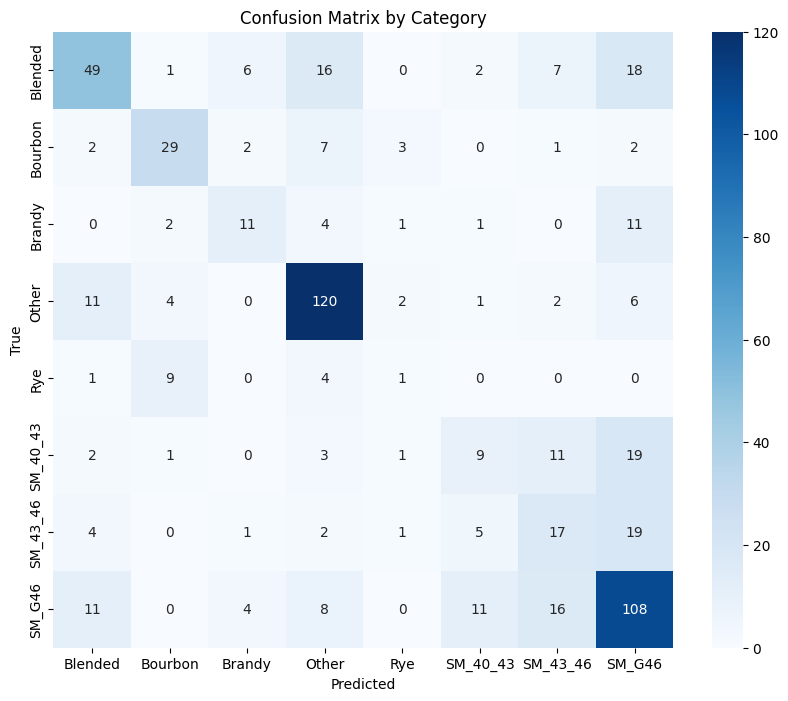

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측
y_pred = np.argmax(model.predict(test_images), axis=1)

# 클래스별 정확도, 정밀도, 재현율, F1 점수 출력
report = classification_report(
    test_labels,
    y_pred,
    target_names=le.classes_,
    digits=3
)
print(report)

# (선택) 혼동 행렬 시각화
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix by Category")
plt.show()